In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
from itertools import chain

# Load complete dataset

In [2]:
data_df = pd.read_csv("../data/complete_data.tsv", sep="\t")
data_df.head(2)

,R4A_Id,CompoundID,PLD_Effect(%)_A549-ACE2,Label_A549-ACE2,HIT_Phospholipidosis Y/N,CompoundID_dupl,NAME,PLD_Effect(%)_VERO-E6,Label_VERO-E6
0,R4A_0001762_001,SPE_A54490543,0.452875,inactive,N,SPE_A54490543,pirlindole,51.51,active
1,R4A_0004935_001,SPE_K28007504,0.826961,active,Y,SPE_K28007504,Ro-60-0175 fumarate,50.67,active


In [3]:
pld_active_ki = set(
    data_df[data_df["Label_A549-ACE2"] == "active"]["CompoundID"].values
)
pld_inactive_ki = set(
    data_df[data_df["Label_A549-ACE2"] == "inactive"]["CompoundID"].values
)
pld_active_itmp = set(
    data_df[data_df["Label_VERO-E6"] == "active"]["CompoundID"].values
)
pld_inactive_itmp = set(
    data_df[data_df["Label_VERO-E6"] == "inactive"]["CompoundID"].values
)

len(pld_active_ki), len(pld_inactive_ki), len(pld_active_itmp), len(pld_inactive_itmp)

(146, 4387, 170, 4288)

# Create venn figure

In [4]:
"""Venn diagram 
Code adapted from - https://github.com/tctianchi/pyvenn/tree/master
"""


def get_labels(data, fill=["number"]):
    """
    get a dict of labels for groups in data
    """

    N = len(data)

    sets_data = [set(data[i]) for i in range(N)]  # sets for separate groups
    s_all = set(chain(*data))  # union of all sets

    # bin(3) --> '0b11', so bin(3).split('0b')[-1] will remove "0b"
    set_collections = {}
    for n in range(1, 2**N):
        key = bin(n).split("0b")[-1].zfill(N)
        value = s_all
        sets_for_intersection = [sets_data[i] for i in range(N) if key[i] == "1"]
        sets_for_difference = [sets_data[i] for i in range(N) if key[i] == "0"]
        for s in sets_for_intersection:
            value = value & s
        for s in sets_for_difference:
            value = value - s
        set_collections[key] = value

    labels = {k: "" for k in set_collections}
    if "logic" in fill:
        for k in set_collections:
            labels[k] = k + ": "
    if "number" in fill:
        for k in set_collections:
            labels[k] += str(len(set_collections[k]))
    if "percent" in fill:
        data_size = len(s_all)
        for k in set_collections:
            labels[k] += "(%.1f%%)" % (100.0 * len(set_collections[k]) / data_size)

    return labels


def draw_ellipse(fig, ax, x, y, w, h, a, fillcolor):
    e = patches.Ellipse(xy=(x, y), width=w, height=h, angle=a, color=fillcolor)
    ax.add_patch(e)


def draw_text(
    fig, ax, x, y, text, color=[0, 0, 0, 1], fontsize=14, ha="center", va="center"
):
    ax.text(
        x,
        y,
        text,
        horizontalalignment=ha,
        verticalalignment=va,
        fontsize=fontsize,
        color="black",
    )


def venn4(data, names=["A", "B", "C", "D"], save=False, save_path=None, **options):
    """
    plots a 4-set Venn diagram

    input
      data: a list of sets
      names:  group names
      more:   colors, figsize, dpi, fontsize
    """

    sns.set(style="white")
    default_colors = [
        # r, g, b, a
        [92, 192, 98, 0.5],
        [90, 155, 212, 0.5],
        [246, 236, 86, 0.6],
        [241, 90, 96, 0.4],
        [255, 117, 0, 0.3],
        [82, 82, 190, 0.2],
    ]
    default_colors = [
        [i[0] / 255.0, i[1] / 255.0, i[2] / 255.0, i[3]] for i in default_colors
    ]

    if (data is None) or len(data) != 4:
        raise Exception("length of data should be 4!")
    if (names is None) or (len(names) != 4):
        names = ("set 1", "set 2", "set 3", "set 4")

    colors = options.get("colors", default_colors)
    figsize = options.get("figsize", (10, 12))
    dpi = options.get("dpi", 96)
    fontsize = options.get("fontsize", 14)

    fig = plt.figure(0, figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111, aspect="equal")
    ax.set_axis_off()
    ax.set_ylim(bottom=0.0, top=1.0)
    ax.set_xlim(left=0.0, right=1.0)

    fill_typ = options.get("fill", "number")
    labels = get_labels(data, fill=fill_typ)

    # body
    draw_ellipse(fig, ax, 0.350, 0.400, 0.72, 0.45, 140.0, colors[0])
    draw_ellipse(fig, ax, 0.450, 0.500, 0.72, 0.45, 140.0, colors[1])
    draw_ellipse(fig, ax, 0.544, 0.500, 0.72, 0.45, 40.0, colors[2])
    draw_ellipse(fig, ax, 0.644, 0.400, 0.72, 0.45, 40.0, colors[3])
    draw_text(fig, ax, 0.85, 0.42, labels.get("0001", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.68, 0.72, labels.get("0010", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.77, 0.59, labels.get("0011", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.32, 0.72, labels.get("0100", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.71, 0.30, labels.get("0101", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.66, labels.get("0110", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.65, 0.50, labels.get("0111", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.14, 0.42, labels.get("1000", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.17, labels.get("1001", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.29, 0.30, labels.get("1010", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.39, 0.24, labels.get("1011", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.23, 0.59, labels.get("1100", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.61, 0.24, labels.get("1101", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.35, 0.50, labels.get("1110", ""), fontsize=fontsize)
    draw_text(fig, ax, 0.50, 0.38, labels.get("1111", ""), fontsize=fontsize)

    # legend
    draw_text(fig, ax, 0.13, 0.18, names[0], colors[0], fontsize=fontsize, ha="right")
    draw_text(
        fig,
        ax,
        0.18,
        0.83,
        names[1],
        colors[1],
        fontsize=fontsize,
        ha="right",
        va="bottom",
    )
    draw_text(
        fig,
        ax,
        0.82,
        0.83,
        names[2],
        colors[2],
        fontsize=fontsize,
        ha="left",
        va="bottom",
    )
    draw_text(
        fig, ax, 0.87, 0.18, names[3], colors[3], fontsize=fontsize, ha="left", va="top"
    )
    leg = ax.legend(names, loc="center left", bbox_to_anchor=(1.0, 0.5), fancybox=True)
    leg.get_frame().set_alpha(0.5)

    plt.tight_layout()
    if save:
        plt.savefig(save_path, dpi=400)
    plt.show()

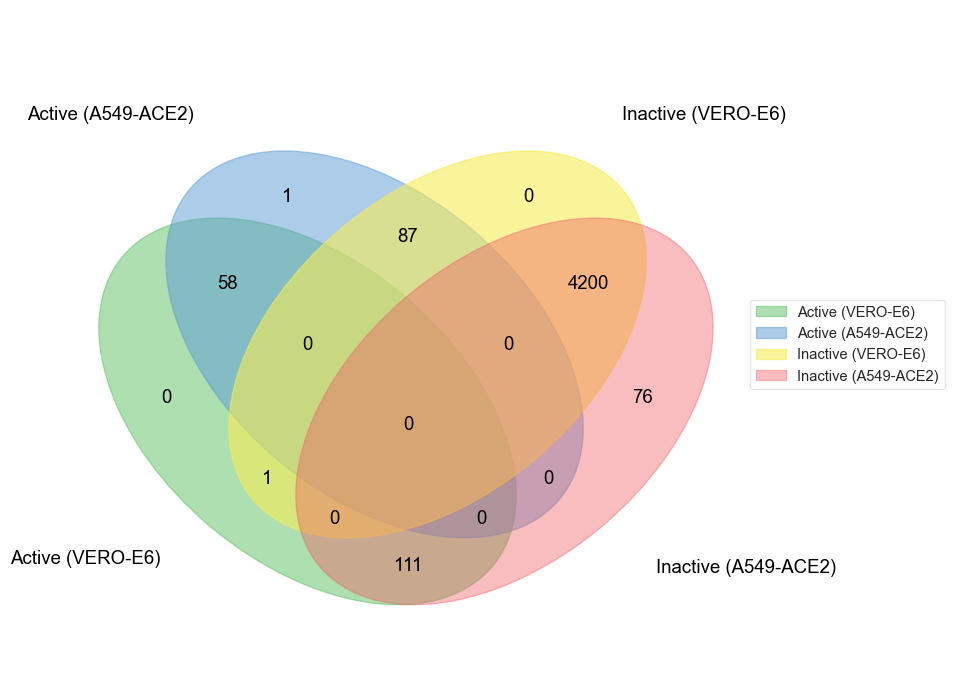

In [5]:
venn4(
    [
        pld_active_itmp,
        pld_active_ki,
        pld_inactive_itmp,
        pld_inactive_ki,
    ],
    [
        "Active (VERO-E6)",
        "Active (A549-ACE2)",
        "Inactive (VERO-E6)",
        "Inactive (A549-ACE2)",
    ],
    options={"dpi": 400},
    save=True,
    save_path="../figures/figure_2.png",
)